# Week 2 case studies

## Low birth weight

One of the examples we looked at of causal reasoning was the [low birth weight paradox](https://academic.oup.com/aje/article/164/11/1115/61454). Here we go through the article above at a high level.

In [1]:
%%javascript
require.config({
    paths: { 
        d3: 'https://d3js.org/d3.v5.min'
    }
});

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from dag import draw_dag

%matplotlib inline

<IPython.core.display.Javascript object>

## 1. Estimate raw data

From Figure 1 in the paper, distributions of birth weights look approximately normal. We have

- LBW: 2500 grams or less
- $\mu_{\text{smoker}}$ = 3145g, $P(\text{LBW}|\text{smoker}) = 0.114$
- $\mu_{\text{non-smoker}}$ = 3370g, $P(\text{LBW}|\text{non-smoker}) = 0.064$
- $P(\text{infant death}|\text{smoker}) = 1235/100,000$
- $P(\text{infant death}|\text{non-smoker}) = 805/100,000$ 

Let's estimate the standard deviation for each population and recreate figure 1:

In [3]:
LOW_BIRTH_WEIGHT = 2500

def estimate_std_dev(prob_lbw, pop_mean):
    z_score_from_cdf = norm.ppf(prob_lbw)
    # z_lbw = (2500 - mean)/sigma
    stddev = (LOW_BIRTH_WEIGHT - pop_mean) / z_score_from_cdf 
    return stddev

mu_smoker, mu_nonsmoker = 3145, 3370
std_smoker = estimate_std_dev(0.114, mu_smoker)
std_nonsmoker = estimate_std_dev(0.064, mu_nonsmoker)

In [4]:
std_smoker

535.0358052221212

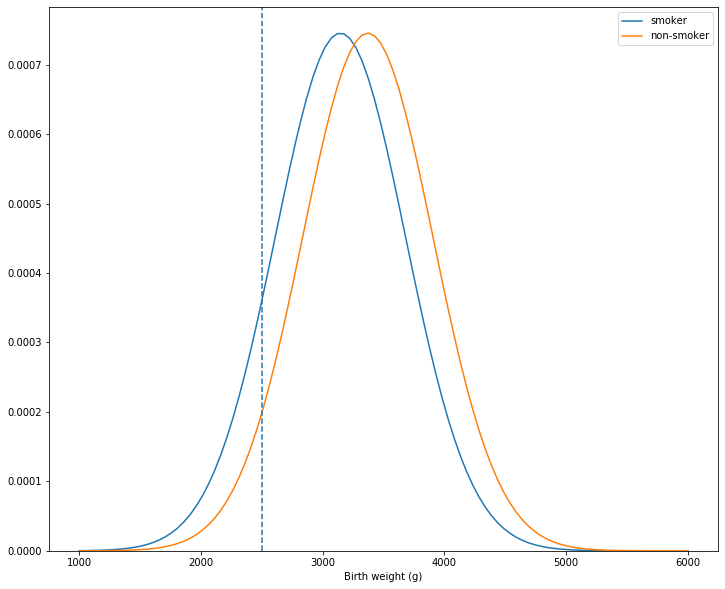

In [5]:
plt.figure(figsize=(12,10))
W = np.linspace(1000, 6000, 100)
plt.plot(W, norm(loc=mu_smoker, scale=std_smoker).pdf(W), label='smoker')
plt.plot(W, norm(loc=mu_nonsmoker, scale=std_smoker).pdf(W), label='non-smoker')
plt.axvline(LOW_BIRTH_WEIGHT, ls='--')
plt.legend()
plt.ylim(0,)
plt.xlabel('Birth weight (g)');

**Random trivia:**
- California was excluded (lack of smoking data!)
- There were 4.1 million births (prior to exclusions)



![Birth weight graph](birth_weight.jpg)

This figure is a little harder to reconstruct, but a [separate paper](https://academic.oup.com/aje/article/164/11/1121/61509) by the same author has an example to illustrate (note this is different from the real example)

Even though smokers saw a higher rate of infant mortality (1.235% vs 0.805%), pretty much at any given birth weight, babies born to smoking women have a higher (or same) survival rate.

The numerical reason for this paradox is clear: the death rate is a lot higher for all populations at low birth weight (and looks indistinguishable, at least graphically). Smokers tend to have lower birth weight babies, so the overall death rate is higher.

The question is whether we should (or should not) stratify on weight. 
- Argument for not stratifying on weight: smoking is the thing that _causes_ LBW, so we shouldn't ignore it.
  Consequence: Mother's should not smoke.
- Argument for stratifying on weight: smoking and LBW may have a common cause (e.g. poor diet, socio-economic class, etc), and have no causal effect on one another. We can then stratify on birth weight and show smoking has almost no effect (for babies < 2000g) and a mild beneficial effect (for babies > 2000g)

Since the health recommendation is different, it makes a real difference whether we choose to stratify / regress on weight or not.

### DAG1: Smoking's effects are mediated by birth weight

Assumption:
- Smoking has no (direct) effect on infant mortality
- Smoking does cause LBW, and LBW babies have higher mortality
- We should not regress on smoking, and conclude 'don't smoke'

In [6]:
positions = {'smoking': [50, 100], 'LBW': [200, 100], 'Mortality': [350, 100]}
draw_dag({'smoking': ['LBW'], 'LBW': ['Mortality']}, positions=positions)

<IPython.core.display.Javascript object>

We can reject this DAG: If the only effect was via LBW, then figure 2 should show 2 curves lying on top of one another.

## DAG2: Smoking is a confounder between LBW and mortality

In [7]:
draw_dag({'smoking': ['LBW', 'Mortality']}, 
         positions={'smoking': [300, 100], 'LBW':[100, 300], 'Mortality': [500,300]})

<IPython.core.display.Javascript object>

If this were the case, we would expect in each strata of `smoking` to have a mortality rate that was independent of birth weight (i.e. a horizontal line for smoking, and a horizontal line for non-smoking). This is at odds with the data.

i.e. In this DAG, the paradox simply would not arise (and it wouldn't matter if you include weight in the regression or not)

**Note** I am being a little sloppy here. Technically there can still be variation of mortality that depends on weight, just not whether you are "low weight" or not. There are (contrived) distributions where there is variation between <2500g and >2500g, but the only information you had is which side of that line you were on, it would be flat.

### DAG 3: Mediation and direct effect

This is the "drug with blood pressure" example we have seen from chapter 1

In [8]:
draw_dag({'smoking': ['LBW', 'mortality'], 'LBW': ['mortality']},
         positions={'LBW': [300, 100], 'smoking':[100, 300], 'mortality': [500,300]})

<IPython.core.display.Javascript object>

This DAG is consistent with the data (but would be consistent with any data). If this were true, we would decide smoking is harmful via it's influence on birth weight, but confers other beneficial effects.

- To isolate the beneficial effects, we should control for birth weight.
- To see the overall effect smoking has, we should not control for birth weight.

### DAG 6: Enter the unknown

This is very similar to DAG 2, except there are unknown or unmeasured factors that contribute to both LBW and to mortality (e.g. socio-ecnomic status). This would induce a relationship between LBW and mortality, even if birth weight had nothing to do with mortality:

In [9]:
draw_dag({'U': ['LBW', 'Mortality'], 'Smoking': ['LBW', 'Mortality']},
        positions={'Smoking': [300, 100], 'LBW':[200, 200], 'Mortality': [200,400], 'U': [100, 100]})

<IPython.core.display.Javascript object>

If we _don't_ regress on weight, then weight acts as a collider - it blocks information from flowing from $U$ to smoking, and the coefficient of the line from smoking to mortality tells us about the effect.

If we _do_ regress on weight, then the collider is unblocked, the information from the unknown factors leak into the estimate of smoking's effect on mortality.

The way to think about this is:
- a LBW baby to a non-smoker would have been "unlucky" with it's draw from other factors, which increases its chance of death.
- a baby of the same weight to a smoker would have been luck(ier) with its draw from $U$, because $U$ has undone some of the effect of smoking of lowering the birth weight. i.e. If this person had not smoked, the baby would be even heavier. From the point of view of mortality, the baby "pays" the smoking penalty, but recieved a larger boon from other factors, making the comparison different than the baby with the same factors born to a non-smoking parent.

Let's see if we can simulate this:

In [10]:
N = 100_000

U = np.random.normal(size=N, scale=255)
Smoking = (np.random.random(size=N)<0.33)  # say 33% of population smoke
Smoking_effect = np.random.normal(size=N, loc=-200, scale=50) * Smoking
weight = np.random.normal(size=N, loc=3100, scale=35) + U + Smoking_effect

LBW = weight < 2500

logit = (U + Smoking_effect)/500 - 3.5

probs = 1/(1 + np.exp(-logit))
mortality = (np.random.random(size=N) < probs)

In [11]:
logit

array([-2.90089735, -3.09596459, -2.49793403, ..., -3.81990273,
       -3.46344816, -3.99801617])

In [12]:
df = pd.DataFrame({'smoking': Smoking, 'weight': weight, 'LBW': LBW, 'mortality': mortality})

In [13]:
df.groupby(['smoking', 'LBW'], as_index=False).mortality.mean()

,smoking,LBW,mortality
0,False,False,0.031681
1,False,True,0.013043
2,True,False,0.023704
3,True,True,0.008950


In [14]:
df.drop('weight', axis=1).pivot_table(index='smoking', columns=['LBW'], aggfunc='mean')

mortality          
LBW         False     True 
smoking                    
False    0.031681  0.013043
True     0.023704  0.008950